In [12]:
using PorousMaterials
using JLD2
using PyPlot
using PyCall

PyPlot.matplotlib.style.use("ggplot")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [13]:
set_paths(joinpath(pwd(), "../data"))

In [14]:
xtal = Crystal("05000N2.cif")
temperature = 298.0
ljff = LJForceField("UFF")

adsorbates = Molecule.(["Kr", "Xe"])
mol_fxn    = [0.8, 0.2]
total_pressure = 1.0 # bar
partial_p = total_pressure .* mol_fxn

###
#  number of cycles spanned by set of simulations
###
num_cycles = Int.(floor.(10 .^ range(log10(25), stop=log10(150000), length=100)));

num_ins_per_vol = Int.(floor.(10 .^ range(log10(25), stop=3, length=100)));

┌ Info: Crystal 05000N2.cif has  space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/dev/Xtals/src/crystal.jl:433


### Data retrieval functions

**GCMC**

In [15]:
function get_gcmc_sim_data(xtal, adsorbates)
    # define dict to store data
    data = Dict{Tuple{String, Int64}, Dict{String, Any}}()
    
    # get data from μVT_sim results dict
    for n in num_cycles
        n_burn_cycles   = n
        n_sample_cycles = n
        filename = μVT_output_filename(xtal, adsorbates, 
                                       temperature, partial_p, 
                                       ljff, n_burn_cycles, n_sample_cycles)
        
        file = joinpath(PorousMaterials.rc[:paths][:simulations], filename)
        @load file results
        data[(xtal.name, n)] = results
    end
    
    return data
end

"""
# Returns
- `vals::Dict{Tuple{Symbol, String}, Array{Union{Float64, Int64}, 1}}`
- `elapsed_t::Array{Float64, 1}`
"""
function get_gcmc_vals_and_errors(xtal::Crystal, 
                                  adsorbates::Array{Molecule{Cart}, 1}, 
                                  num_cycles::Array{Int64, 1}, 
                                  data::Dict{Tuple{String, Int64}, Dict{String, Any}})
    
    # define dict to store results
    vals = Dict{Tuple{Symbol, String}, Array{Union{Float64, Int64}, 1}}()
    
    # get 
    for (i, mol) in enumerate(adsorbates)
        vals[(mol.species, "⟨N⟩ (mmol/g)")] = [data[(xtal.name, n)]["⟨N⟩ (mmol/g)"][i] for n in num_cycles]
        vals[(mol.species, "err ⟨N⟩ (mmol/g)")] = [data[(xtal.name, n)]["err ⟨N⟩ (mmol/g)"][i] for n in num_cycles]
    end
    
    # get runtime data [minutes]
    elapsed_t = [data[(xtal.name, n)]["elapsed_time"] for n in num_cycles] ./ 60
    
    return vals, elapsed_t
end

get_gcmc_vals_and_errors

**Henry**

In [16]:
function get_henry_sim_data(xtal::Crystal, 
                            molecule::Molecule{Cart}, 
                            ins_per_vol::Array{Int64, 1})
    # define dict to store data
    data = Dict{Tuple{String, Int64}, Dict{String, Any}}()
    
    for n in ins_per_vol
        filename = henry_result_savename(xtal, molecule, temperature, ljff, n)
        
        file = joinpath(PorousMaterials.rc[:paths][:simulations], filename)
        @load file results
        data[(xtal.name, n)] = results
    end
    
    return data
end


function get_henry_vals_and_errors(xtal::Crystal, 
                                   adsorbates::Array{Molecule{Cart}, 1}, 
                                   ins_per_vol::Array{Int64, 1}, 
                                   data_array::Array{Dict{Tuple{String, Int64}, Dict{String, Any}}, 1})
    
    @assert length(data_array) == length(adsorbates)
    
    # define dict to store results
    vals = Dict{Tuple{Symbol, String}, Array{Union{Float64, Int64}, 1}}()
    elapsed_t = zeros(length(ins_per_vol))
    
    # get 
    for (i, mol) in enumerate(adsorbates)
        vals[(mol.species, "henry coefficient [mmol/(g-bar)]")] = 
            [data_array[i][(xtal.name, n)]["henry coefficient [mmol/(g-bar)]"] for n in ins_per_vol]
        
        vals[(mol.species, "err henry coefficient [mmol/(g-bar)]")] = 
            [data_array[i][(xtal.name, n)]["err henry coefficient [mmol/(g-bar)]"] for n in ins_per_vol]
        
        # total time to run sim for all adsorbates [min]
        elapsed_t += [data_array[i][(xtal.name, n)]["elapsed time (min)"] for n in ins_per_vol]
    end
    
#     # get runtime data
#     elapsed_t = [data_array[(xtal.name, n)]["elapsed time (min)"] for n in ins_per_vol]
    
    return vals, elapsed_t
end

get_henry_vals_and_errors (generic function with 1 method)

## plotting function

In [17]:
function plot_gcmc_results_vs_cycles(xtal::Crystal, 
                                     vals::Dict{Tuple{Symbol, String}, Array{Union{Float64, Int64}, 1}}, 
                                     elapsed_t::Array{Float64, 1}, 
                                     adsorbates::Array{Molecule{Cart}, 1}, 
                                     num_cycles::Array{Int64, 1}; 
                                     save_fig::Bool=false)
    
    # create subplot
    fig, axs = subplots(2, 1, sharex=true, figsize=(8, 10))
    axs2 = axs[1].twinx()
    
    ###
    # plot data
    ###
    for (i, mol) in enumerate(adsorbates)
        axs[1].errorbar(num_cycles, vals[(mol.species, "⟨N⟩ (mmol/g)")], 
                        yerr=vals[(mol.species, "err ⟨N⟩ (mmol/g)")], 
                        marker="o", markersize=3, linestyle="",
                        label=String(mol.species), 
                        color="C$(i-1)", zorder=1)
        
        axs[2].semilogx(num_cycles, vals[(mol.species, "err ⟨N⟩ (mmol/g)")], 
                        label=String(mol.species), color="C$(i-1)")
    end

    axs2.plot(num_cycles, elapsed_t, label="elapsed time", color="k", alpha=0.7)
    
    ###
    #  format plot properties
    ###
    axs[1].legend(loc="lower right")
    
    axs[1].set_title(xtal.name)
    axs[1].set_xlabel("total # cycles")
    axs[1].set_ylabel("⟨N⟩ (mmol/g)")
    axs2.legend(loc="best")
    axs2.grid(false)
    axs2.set_ylabel("time [min]")

    axs[2].set_xlim(xmin=10)
    axs[2].legend(loc="best")
    axs[2].set_xlabel("total # cycles")
    axs[2].set_ylabel("err ⟨N⟩ (mmol/g)")

    tight_layout()
    if save_fig
        savefig(xtal.name * "_cycles_vs_uptake_error.png", dpi=600, format="png")
    end
    
    return
end

plot_gcmc_results_vs_cycles (generic function with 1 method)

In [18]:
function plot_henry_results_vs_cycles(xtal::Crystal, 
                                      vals::Dict{Tuple{Symbol, String}, Array{Union{Float64, Int64}, 1}}, 
                                      elapsed_t::Array{Float64, 1}, 
                                      adsorbates::Array{Molecule{Cart}, 1}, 
                                      num_ins_per_vol::Array{Int64, 1}; 
                                      save_fig::Bool=false)
    # create subplot
    fig, axs = subplots(2, 1, sharex=true, figsize=(8, 10))
    axs2 = axs[1].twinx()
    
    ###
    # plot data
    ###
    for (i, mol) in enumerate(adsorbates)
        axs[1].errorbar(num_ins_per_vol, vals[(mol.species, "henry coefficient [mmol/(g-bar)]")], 
                        yerr=vals[(mol.species, "err henry coefficient [mmol/(g-bar)]")], 
                        marker="o", markersize=3, linestyle="",
                        label=String(mol.species), 
                        color="C$(i-1)", zorder=1)
        
        axs[2].semilogx(num_ins_per_vol, vals[(mol.species, "err henry coefficient [mmol/(g-bar)]")], 
                        label=String(mol.species), color="C$(i-1)")

    end

                
    axs2.plot(num_ins_per_vol, elapsed_t, label="elapsed time", color="k", alpha=0.7)
    
    
    ###
    #  format plot properties
    ###
    axs[1].legend(loc="lower right")
    
    axs[1].set_title(xtal.name)
    axs[1].set_xlabel("insertions per volume")
    axs[1].set_ylabel("H [mmol/(g-bar)]")
    axs2.legend(loc="best")
    axs2.grid(false)
    axs2.set_ylabel("time [min]")

    axs[2].set_xlim(xmin=10)
    axs[2].legend(loc="best")
    axs[2].set_xlabel("insertions per volume")
    axs[2].set_ylabel("err H [mmol/(g-bar)]")

    tight_layout()
    if save_fig
        savefig(xtal.name * "_insertions_per_vol_vs_uptake_error.png", dpi=600, format="png")
    end
    
    return
end

plot_henry_results_vs_cycles (generic function with 1 method)

## Plot Analysis 

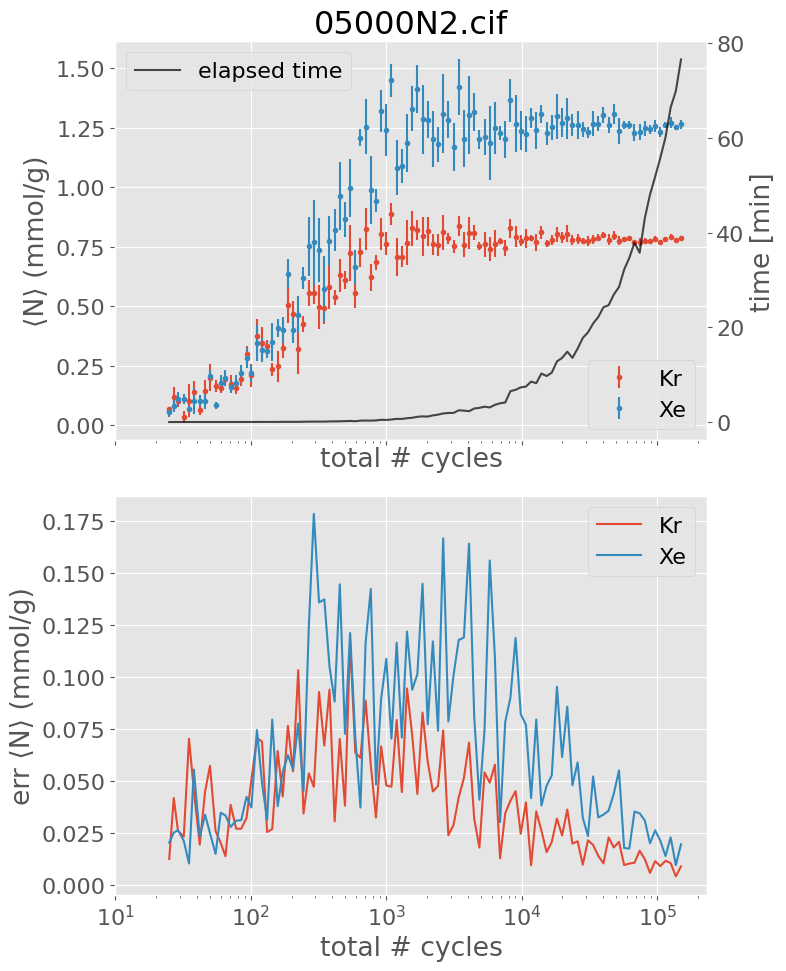

In [19]:
data = get_gcmc_sim_data(xtal, adsorbates)
vals, elapsed_t = get_gcmc_vals_and_errors(xtal, adsorbates, num_cycles, data)

plot_gcmc_results_vs_cycles(xtal, vals, elapsed_t, adsorbates, num_cycles; save_fig=true)

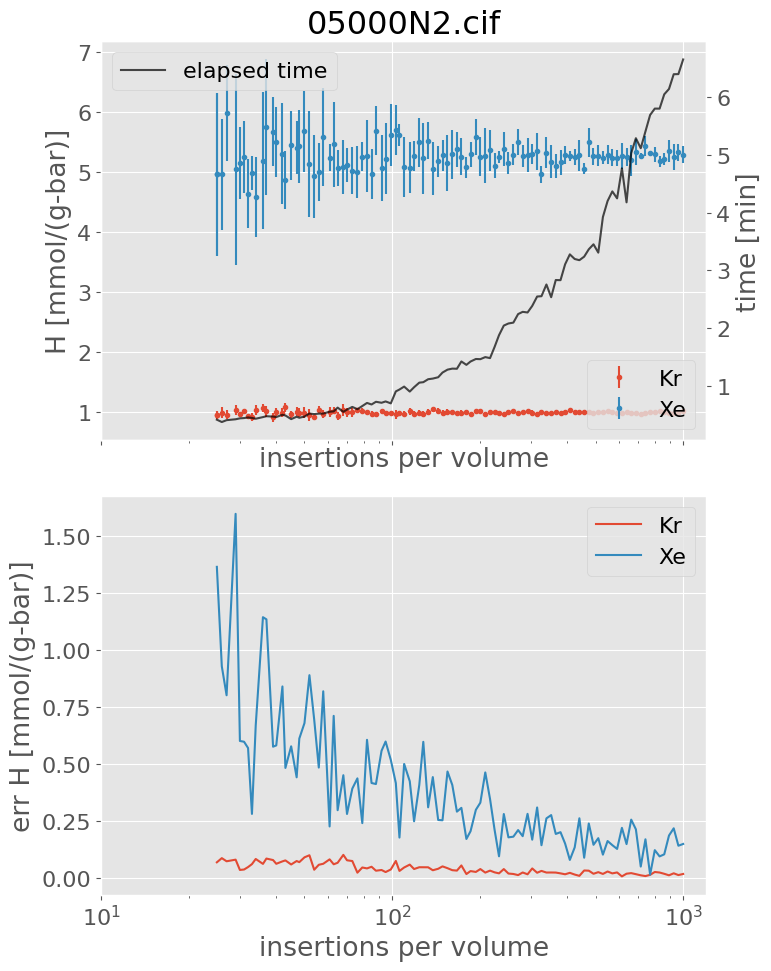

In [20]:
data_array = Dict{Tuple{String, Int64}, Dict{String, Any}}[]
[push!(data_array, get_henry_sim_data(xtal, molecule, num_ins_per_vol)) for molecule in adsorbates]

vals, time = get_henry_vals_and_errors(xtal, adsorbates, num_ins_per_vol, data_array)

plot_henry_results_vs_cycles(xtal, vals, time, adsorbates, num_ins_per_vol; save_fig=true)

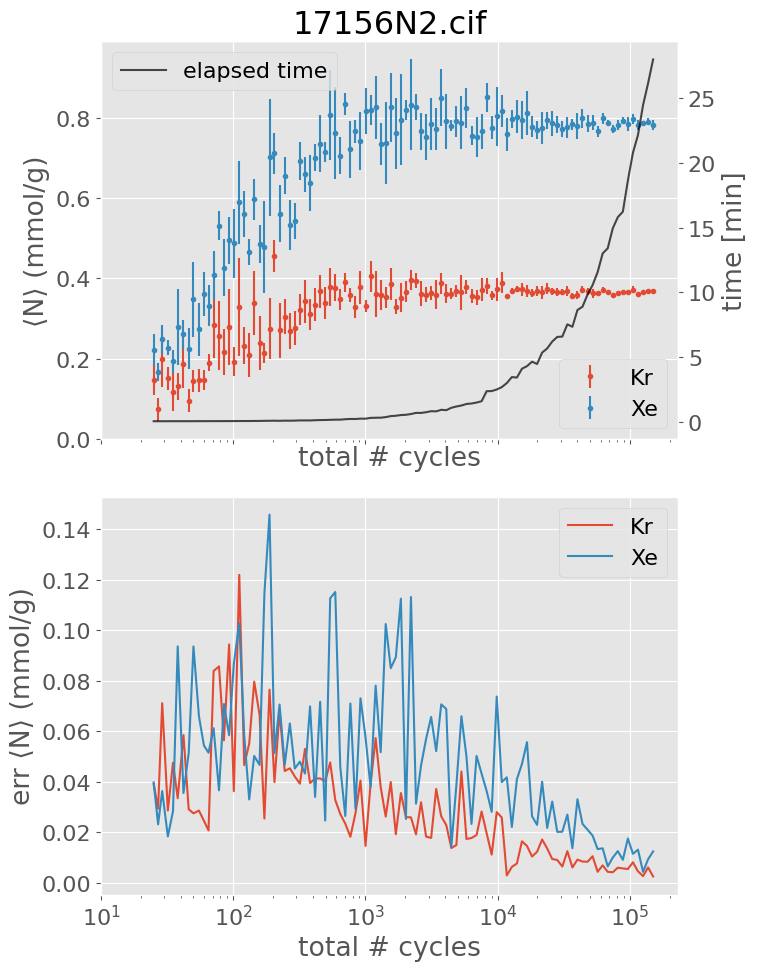

┌ Info: Crystal 17156N2.cif has  space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/dev/Xtals/src/crystal.jl:433


In [21]:
xtal = Crystal("17156N2.cif")
data = get_gcmc_sim_data(xtal, adsorbates)
vals, elapsed_t = get_gcmc_vals_and_errors(xtal, adsorbates, num_cycles, data)

plot_gcmc_results_vs_cycles(xtal, vals, elapsed_t, adsorbates, num_cycles)

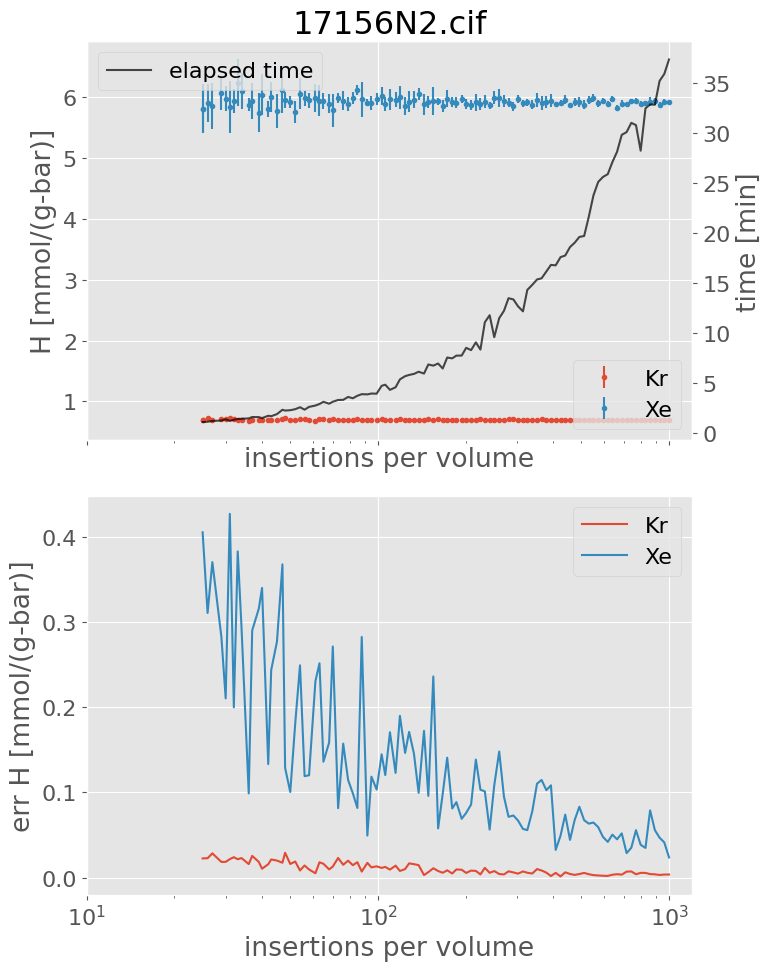

In [22]:
data_array = Dict{Tuple{String, Int64}, Dict{String, Any}}[]
[push!(data_array, get_henry_sim_data(xtal, molecule, num_ins_per_vol)) for molecule in adsorbates]

vals, time = get_henry_vals_and_errors(xtal, adsorbates, num_ins_per_vol, data_array)

plot_henry_results_vs_cycles(xtal, vals, time, adsorbates, num_ins_per_vol; save_fig=true)